Notebook to send jobs to the Ubelix HPC cluster at the University of Bern

In [1]:
import sys
import os
import logging
import glob
import pickle
import json
from pathlib import Path
import rpy2.robjects as ro
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

%load_ext rpy2.ipython

logging.basicConfig(filename='example.log', 
                    encoding='utf-8', level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler(stream=sys.stdout))

datapath = Path("../data")
#datapath = Path("/storage/homefs/pd21v747/datanew")

modpath = Path("../scripts")
sys.path.append(os.path.relpath(modpath))

from misc import Timer, pickler, open_table

/storage/homefs/pd21v747/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/storage/homefs/pd21v747/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
include_unpaired_cancer = True

sites = {"liver": "LIHC",
         "thyroid": "THCA",
         "lung": "LUAD",
             "kidney": "KIRC",
         "colorectal": "COAD",
         "breast": "BRCA",
         "prostate": "PRAD",
         "GSETB":"LWPL", # unpaired only
         #"GSEBP":"BPLT", # unpaired only
         "GSEPN":"GIPF"} # unpaired only

if include_unpaired_cancer:
    sites = sites | {"kidney_unpaired":"KIRC_unpaired",
                    "thyroid_unpaired":"THCA_unpaired",
                    "prostate_unpaired":"PRAD_unpaired",
                    "liver_unpaired":"LIHC_unpaired",
                    "lung_unpaired":"LUAD_unpaired",
                    "colorectal_unpaired":"COAD_unpaired",
                    "breast_unpaired":"BRCA_unpaired"}

datasets = {sites[s]: {} for s in sites}
unpaired_data = ["LWPL","BPLT","GIPF"] + [s for s in sites.keys() if "unpaired" in s]

for s in sites:
    f = Path(f"{datapath}/{s}/{sites[s]}/{sites[s]}.csv")
    df = pd.read_csv(f, index_col=0)
    datasets[sites[s]]["genes"] = len(df)
    datasets[sites[s]]["site"] = s
    datasets[sites[s]]["datapath"] = f
    datasets[sites[s]]["outpath"] = f.parent
    datasets[sites[s]]["patients"] = len(df.columns)//2
    print(f"{s:<10}", datasets[sites[s]]["genes"], datasets[sites[s]]["patients"])
    
# Pretty names
cleanout = {"jk": "ReBoost",
            "pcah": "rPCA",
            "none": "None"}
cleandea = {"edger": "edgeR QLF",
            "edgerlrt": "edgeR LRT",
            "deseq2": "DESeq2",
            "wilcox": "Wilcoxon rank-sum"}

liver      15611 50
thyroid    18953 58
lung       18235 52
kidney     18489 72
colorectal 17336 39
breast     18758 111
prostate   18908 51
GSETB      19961 50
GSEPN      18838 102
kidney_unpaired 18489 72
thyroid_unpaired 18953 58
prostate_unpaired 18908 51
liver_unpaired 15611 50
lung_unpaired 18235 52
colorectal_unpaired 17336 39
breast_unpaired 18758 111


# Differential expression analysis

## Define ground truth

Define ground truth DEGs for a given FDR, logFC cutoff as the intersection of DEGs from all three DEA tests (Wald, LRT, QLF)

In [3]:
from DEA import run_dea_on_full_data
from process import find_ground_truth

DEAs = ["edgerlrt", "edgerqlf", "deseq2", "wilcox"]
truth_defining_DEAs = ["edgerlrt", "edgerqlf", "deseq2"] # wilcoxon was added later

FDRs = [0.1,0.05,0.01,0.001]
logFCs = [0, 1] # formal lfc threhsold in edger or deseq2
logFCs_post = [0,0.5,1,1.5,2] # post hoc thresholds

paired = {key:value for key, value in datasets.items() if key not in unpaired_data}
print(f"Running {len(paired)} paired")
run_dea_on_full_data(paired, DEAs, overwrite = False, lfcs = logFCs, design="paired")

unpaired = {key:value for key, value in datasets.items() if key in unpaired_data}
print(f"Running {len(unpaired)} unpaired")
run_dea_on_full_data(unpaired, DEAs, overwrite = False, lfcs = logFCs, design="unpaired")

print("Finding ground truth")
datasets = find_ground_truth(datasets, truth_defining_DEAs, FDRs, logFCs_post, lfc_tests = [0,1], save=True, overwrite=0) # overwrite True if new dataset added
#datasets = find_ground_truth(datasets, truth_defining_DEAs, FDRs, [1], lfc_test = 1)

Running 14 paired
Running 2 unpaired
Finding ground truth


In [4]:
# from process import find_ground_truth

# # # Calcualte ground truth stats with with Wilcoxon just for one figure
# datasets_with_wilcox = find_ground_truth(datasets, DEAs, FDRs, logFCs_post, lfc_tests = [0], save=False, overwrite=1) # don't save
# pickler(datasets_with_wilcox, "../data/multi/stats_dict_wilcox.txt")

## Send batch jobs for selected data set

In [5]:
selected_data = "BRCA_unpaired"
outpath = datasets[selected_data]["outpath"]
outname = outpath.name
outpath, outname

(PosixPath('../data/breast_unpaired/BRCA_unpaired'), 'BRCA_unpaired')

In [6]:
from ubelix import run_multi_batch

script_path = Path("../scripts/send_batch.sh")
DEA_methods = ["edgerqlf","edgerlrt", "deseq2"]#, "wilcox"] # finish edgerqlf jobs before sending other jobs
outlier_methods = ["none"]#, "pcah", "jk"] # only use none for p2 and p3
all_N = [3,7,15]#4,5,6,7,8,9,10,12,15]
n_cohorts = 100

assert outname in str(outpath)

# lfc 0 threshold, paired
config_params_1 = {
    
    "param_set": "p1", # id for this set of parameters
    "sampler": "paired",
    
    "overwrite": False, # overwrite existing tabs
    "data": str(outpath) + "/" + outname + ".csv",
    "outpath": str(outpath),
    "outname": outname,
    
    "DEA_methods": DEA_methods,
    "outlier_methods": outlier_methods,
    
    "outlier_kwargs": {
        "none": {},
        "jk": {
            "FDR": 0.01,
            "overwrite": False, # overwrite existing jk tab
            "max_removed_frac": 0.5, # fraction of patients; after 1st iteration, don't jackknife bottom frac patients
            "efficient": True,
            "cols_to_keep": ["FDR"],
            "cleanup": True # remove individual jk tabs and iterations after merger
        },
        "pcah": {"k": 2}
    },
    
    "DEA_kwargs": {
        "edgerqlf": {"filter_expr": False, "cols_to_keep": ["logFC","logCPM","FDR"], "design": "paired"},
        "edgerlrt": {"filter_expr": False, "cols_to_keep": ["logFC","logCPM","FDR"], "test":"lrt", "design": "paired"},
        "deseq2": {"cols_to_keep": ["logFC","logCPM","FDR"], "design": "paired"},
        "wilcox": {"design": "paired"}
    }
    
}

# lfc = 1 threshold, paired
config_params_2 = {
    
    "param_set": "p2", # id for this set of parameters
    "sampler": "paired",
    
    "overwrite": False, # overwrite existing tabs
    "data": str(outpath) + "/" + outname + ".csv",
    "outpath": str(outpath),
    "outname": outname,
    
    "DEA_methods": DEA_methods,
    "outlier_methods": outlier_methods,
    
    "outlier_kwargs": {
        "none": {},
        "jk": {
            "FDR": 0.01,
            "overwrite": False, # overwrite existing jk tab
            "max_removed_frac": 0.5, # fraction of patients; after 1st iteration, don't jackknife bottom frac patients
            "efficient": True,
            "cols_to_keep": ["FDR"],
            "cleanup": True # remove individual jk tabs and iterations after merger
        },
        "pcah": {"k": 2}
    },
    
    "DEA_kwargs": {
        "edgerqlf": {"filter_expr": False, "cols_to_keep": ["logFC","logCPM","FDR"], "lfc": 1, "design": "paired"},
        "edgerlrt": {"filter_expr": False, "cols_to_keep": ["logFC","logCPM","FDR"], "test":"lrt", "lfc": 1, "design": "paired"},
        "deseq2": {"cols_to_keep": ["logFC","logCPM","FDR"],"lfc": 1, "design": "paired"}
    }
    
}

# lfc = 1 threshold, unpaired analysis (for data that is unpaired)
config_params_3 = {
    
    "param_set": "p3", # id for this set of parameters
    "sampler": "paired",
    
    "overwrite": False, # overwrite existing tabs
    "data": str(outpath) + "/" + outname + ".csv",
    "outpath": str(outpath),
    "outname": outname,
    
    "DEA_methods": DEA_methods,
    "outlier_methods": outlier_methods,
    
    "outlier_kwargs": {
        "none": {},
        "jk": {},
        "pcah": {}
    },
    
    "DEA_kwargs": {
        "edgerqlf": {"filter_expr": False, "cols_to_keep": ["logFC","logCPM","FDR"], "lfc": 1, "design": "unpaired"},
        "edgerlrt": {"filter_expr": False, "cols_to_keep": ["logFC","logCPM","FDR"], "test":"lrt", "lfc": 1, "design": "unpaired"},
        "deseq2": {"cols_to_keep": ["logFC","logCPM","FDR"],"lfc": 1, "design": "unpaired"}
    }
    
}

# lfc = 1 threshold, unpaired analysis, unpaired sampler (for data that is paired)
config_params_4 = {
    
    "param_set": "p4", # id for this set of parameters
    "sampler": "unpaired",
    
    "overwrite": False, # overwrite existing tabs
    "data": str(outpath) + "/" + outname + ".csv",
    "outpath": str(outpath),
    "outname": outname,
    
    "DEA_methods": DEA_methods,
    "outlier_methods": outlier_methods,
    
    "outlier_kwargs": {
        "none": {},
        "jk": {},
        "pcah": {}
    },
    
    "DEA_kwargs": {
        "edgerqlf": {"filter_expr": False, "cols_to_keep": ["logFC","logCPM","FDR"], "lfc": 1, "design": "unpaired"},
        "edgerlrt": {"filter_expr": False, "cols_to_keep": ["logFC","logCPM","FDR"], "test":"lrt", "lfc": 1, "design": "unpaired"},
        "deseq2": {"cols_to_keep": ["logFC","logCPM","FDR"],"lfc": 1, "design": "unpaired"}
    }
    
}

import subprocess as sp
output = sp.getoutput('squeue -u pd21v747')
jobs_running = output.find("send_bat") > 0

#mode = "send jobs" 

# SBATCH with srun does not work from interactive session in newer version of slurm
# https://harvardmed.atlassian.net/wiki/spaces/O2/pages/1586793613/Troubleshooting+Slurm+Jobs#Jobs-fail-with-the-message%3A-Unable-to-satisfy-CPU-bind-request
# workaround: use mode=just testing, copy the command and send job from terminal in submit node
# must set job time/mem manually in shell script

###########################################################################
#### wd must be notebooks folder, must load environment beforehand!!!!#####
###########################################################################

#mode = "test main terminal"
mode = "just testing"

import sys, importlib
importlib.reload(sys.modules["ubelix"])
from ubelix import run_multi_batch

do_nothing = True
config_params = config_params_4

if not jobs_running and not do_nothing:
    run_multi_batch(config_params, all_N, n_cohorts, script_path, mode = mode)
elif jobs_running:
    print("Jobs running")

In [7]:
!squeue -u pd21v747

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          11516339     epyc2 jupyter_ pd21v747  R    1:10:06      1 bnode034


## Process jobs

In [21]:
#post hoc
DEAs = ["wilcox", "edgerqlf", "edgerlrt", "deseq2"]
outlier_methods = ["none", "pcah", "jk"]
FDRs = [0.1,0.05,0.01,0.001]
logFCs = [0, 0.5, 1, 1.5, 2]
all_N = [3,4,5,6,7,8,9,10,12,15]
lfc_test = 0
param_set = "p1"

# #formal
DEAs = ["edgerqlf","deseq2", "edgerlrt"]
outlier_methods = ["none"]#, "pcah", "jk"]
FDRs = [0.1,0.05,0.01,0.001]
logFCs = [1]
all_N = [3,4,5,6,7,8,9,10,12,15]
lfc_test = 1
param_set = "p2"

# #unpaired
# DEAs = ["edgerqlf", "edgerlrt", "deseq2"]
# outlier_methods = ["none"]
# FDRs = [0.05] #[0.1,0.05,0.01,0.001]
# logFCs = [1]
# all_N = [3,7,15]
# lfc_test = 1
# param_set = "p3"

#unpaired
DEAs = ["edgerqlf", "edgerlrt", "deseq2"]
outlier_methods = ["none"]
FDRs = [0.05] #[0.1,0.05,0.01,0.001]
logFCs = [1]
all_N = [3,7,15]
lfc_test = 1
param_set = "p4"

param_sets = ["p1","p2","p3","p4"]

In [22]:
from process import process_pipeline
from misc import profile_func
import pstats

kwargs = {"outpath":outpath, "outname":outname, "all_N": all_N, "DEAs":DEAs, "outlier_methods": outlier_methods, 
          "FDRs":FDRs, "logFCs":logFCs, "lfc_test": lfc_test, "param_set":param_set, "overwrite": 1, "overwrite_merged": 1, "n_cohorts": 100}

do_process = False
if do_process:
    prof = profile_func(process_pipeline, kwargs)
    stats = pstats.Stats(prof).strip_dirs().sort_stats("cumtime")
    stats.print_stats(50)

In [10]:
# # Process multiple data sets
# import process, sys, importlib
# importlib.reload(sys.modules["process"])

# from process import process_pipeline

# for data in datasets:
#     print(data)
    
#     outpath = datasets[data]["outpath"]
#     outname = str(outpath).split("/")[-1]
#     kwargs = {"outpath":outpath, "outname":outname, "all_N": all_N, "DEAs":DEAs, "outlier_methods": outlier_methods, 
#               "FDRs":FDRs, "logFCs":logFCs, "lfc_test": lfc_test, "param_set":param_set, "overwrite": 1, "overwrite_merged": 0, "n_cohorts": 100}
#     process_pipeline(**kwargs)

### Merge processed data sets

In [23]:
def load_results(path, site, name, param_set):
    resultsfile = f"{path}/{site}/{name}/results.{param_set}.txt"
    try:
        with open(resultsfile, "rb") as f:
            return pickle.load(f)
    except FileNotFoundError:
        print(f"File not found: {resultsfile}")
    
for s in sites:
    
    #if s not in ["colorectal","prostate","breast","thyroid","liver"]: continue

    for ps in param_sets:
        res = load_results(datapath, s, sites[s], ps)
        if ps not in datasets[sites[s]]:
            datasets[sites[s]][ps] = {}
        if res == None: continue
        for key in res.keys():
            datasets[sites[s]][ps][key] = res[key]

assert "truth_stats" in datasets[list(datasets.keys())[0]] # don't forget to load ground truth
datasetsfile = Path(datapath, "multi/datasets.txt")
pickler(datasets, datasetsfile)

File not found: ../data/liver/LIHC/results.p4.txt
File not found: ../data/thyroid/THCA/results.p4.txt
File not found: ../data/lung/LUAD/results.p4.txt
File not found: ../data/kidney/KIRC/results.p4.txt
File not found: ../data/colorectal/COAD/results.p4.txt
File not found: ../data/breast/BRCA/results.p4.txt
File not found: ../data/prostate/PRAD/results.p4.txt
File not found: ../data/GSETB/LWPL/results.p4.txt
File not found: ../data/GSEPN/GIPF/results.p1.txt
File not found: ../data/GSEPN/GIPF/results.p2.txt
File not found: ../data/GSEPN/GIPF/results.p4.txt
File not found: ../data/kidney_unpaired/KIRC_unpaired/results.p1.txt
File not found: ../data/kidney_unpaired/KIRC_unpaired/results.p2.txt
File not found: ../data/kidney_unpaired/KIRC_unpaired/results.p3.txt
File not found: ../data/thyroid_unpaired/THCA_unpaired/results.p1.txt
File not found: ../data/thyroid_unpaired/THCA_unpaired/results.p2.txt
File not found: ../data/thyroid_unpaired/THCA_unpaired/results.p3.txt
File not found: ../dat

In [24]:
# Create tidy dataframe

def tidy_df(datasets,param_set,logFCs):
    quantity = ["median_rep", "median_deg", "median_rep_adj", "median_deg_adj","median_mcc0", "median_prec0","median_mcc0_adj", "median_prec0_adj",
                "median_mcc", "median_prec", "median_rec", "median_mcc_adj", "median_prec_adj", "median_rec_adj"]
    iterables = [datasets,all_N,outlier_methods,DEAs,FDRs,logFCs,quantity]
    multi_cols = pd.MultiIndex.from_product(iterables, names=["Data", "N", "Out", "DEA", "FDR", "logFC", "Val"])
    combined = pd.DataFrame(columns=multi_cols)

    ids = [] # id connecting samples from same dataset and cohort size, used for paired-sample testing pre vs. post outlier removal
    for i, d in enumerate(datasets):
        #if d not in ["COAD","PRAD","BRCA","THCA","LIHC"]: continue
        for j, N in enumerate(all_N):
            k = i*len(all_N)+j 
            for out in outlier_methods:
                for dea in DEAs:
                    for fdr in FDRs:
                        for logFC in logFCs:
                            for quant in quantity:
                                #print(d,N,param_set,out,dea,quant,fdr,logFC)
                                col = (d,N,out,dea,fdr,logFC,quant)
                                try:
                                    combined.loc[0,col] = datasets[d][param_set][N][out][dea][quant][fdr][logFC]
                                except KeyError:
                                    if "syn_hom" in d and out != "None": pass
                                    else: 
                                        print(d,N,param_set,out,dea,quant,fdr,logFC)
                                        combined.loc[0,col] = datasets[d][param_set][N][out][dea][quant][fdr][logFC]
                                        raise Exception("KeyError")
                                if quant == "median_rep": ids.append(k)

    combined_td = combined.unstack().unstack(level="Val").reset_index(level=["Data","N","Out","DEA","FDR","logFC"], drop=False)
    combined_td["id"] = ids
    combined_td.reset_index(drop=True, inplace=True)

    # For outlier_method == "none", no adjustment is necessary, hence copy unadjusted values
    none_ix = combined_td[combined_td["Out"] == "none"].index # avoid setting with copy warning
    combined_td.loc[none_ix,"median_deg_adj"] = combined_td.loc[none_ix,"median_deg"]
    combined_td.loc[none_ix,"median_rep_adj"] = combined_td.loc[none_ix,"median_rep"]
    combined_td.loc[none_ix,"median_mcc_adj"] = combined_td.loc[none_ix,"median_mcc"]
    combined_td.loc[none_ix,"median_mcc0_adj"] = combined_td.loc[none_ix,"median_mcc0"]
    combined_td.loc[none_ix,"median_prec_adj"] = combined_td.loc[none_ix,"median_prec"]
    combined_td.loc[none_ix,"median_prec0_adj"] = combined_td.loc[none_ix,"median_prec0"]
    combined_td.loc[none_ix,"median_rec_adj"] = combined_td.loc[none_ix,"median_rec"]


    for clean in cleanout:
        combined_td.loc[(combined_td[combined_td["Out"] == clean]).index, "Out"] = cleanout[clean]
    for clean in cleandea:
        combined_td.loc[(combined_td[combined_td["DEA"] == clean]).index, "DEA"] = cleandea[clean]
    return combined_td.infer_objects()

In [25]:
# outlier_methods = ["none","jk","pcah"]
# combined_td = tidy_df("p1",[0,1])
# outlier_methods = ["none"]
# combined_td2 = tidy_df("p2",[1])
# combined_td.head()

In [27]:
d = {k: datasets[k] for k in ("PRAD_unpaired","BRCA_unpaired","THCA_unpaired","LIHC_unpaired","LUAD_unpaired","COAD_unpaired","KIRC_unpaired")}
#d = {k: datasets[k] for k in ("GIPF","LWPL","PRAD","BRCA","THCA","LIHC","LUAD","COAD","KIRC")}
#d = datasets

#d = {k: datasets[k] for k in ("PRAD","BRCA","THCA","LIHC","LUAD","COAD","KIRC")}
#combined_td = tidy_df(d, "p2", logFCs=[1])
#combined_td.to_csv(Path(datapath, f"multi/combined_td.{param_set}.csv"))

# d = datasets
combined_td = tidy_df(d, "p4", logFCs=[1])

param_set = "p4"

combined_td.to_csv(Path(datapath, f"multi/combined_td.{param_set}.csv"))
combined_td

Val,Data,N,Out,DEA,FDR,logFC,median_deg,median_deg_adj,median_mcc,median_mcc0,...,median_mcc_adj,median_prec,median_prec0,median_prec0_adj,median_prec_adj,median_rec,median_rec_adj,median_rep,median_rep_adj,id
0,BRCA_unpaired,3,None,DESeq2,0.05,1,330.5,330.5,0.290944,0.290944,...,0.290944,0.881604,0.881604,0.881604,0.881604,0.118001,0.118001,0.107827,0.107827,0
1,BRCA_unpaired,3,None,edgeR LRT,0.05,1,557.5,557.5,0.354941,0.354941,...,0.354941,0.837023,0.837023,0.837023,0.837023,0.191622,0.191622,0.134228,0.134228,0
2,BRCA_unpaired,3,None,edgerqlf,0.05,1,1.0,1.0,0.103780,0.019012,...,0.103780,0.969697,0.782208,0.782208,0.969697,0.000415,0.000415,0.000000,0.000000,0
3,BRCA_unpaired,7,None,DESeq2,0.05,1,533.0,533.0,0.419111,0.419111,...,0.419111,0.944594,0.944594,0.944594,0.944594,0.210908,0.210908,0.249267,0.249267,1
4,BRCA_unpaired,7,None,edgeR LRT,0.05,1,1001.5,1001.5,0.512440,0.512440,...,0.512440,0.856605,0.856605,0.856605,0.856605,0.353795,0.353795,0.300389,0.300389,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,THCA_unpaired,7,None,edgeR LRT,0.05,1,523.5,523.5,0.517848,0.517848,...,0.517848,0.875675,0.875675,0.875675,0.875675,0.329268,0.329268,0.292698,0.292698,19
59,THCA_unpaired,7,None,edgerqlf,0.05,1,241.0,241.0,0.396446,0.382941,...,0.396446,0.953736,0.950314,0.950314,0.953736,0.168514,0.168514,0.137465,0.137465,19
60,THCA_unpaired,15,None,DESeq2,0.05,1,516.0,516.0,0.572848,0.572848,...,0.572848,0.941330,0.941330,0.941330,0.941330,0.363636,0.363636,0.474999,0.474999,20
61,THCA_unpaired,15,None,edgeR LRT,0.05,1,808.0,808.0,0.645163,0.645163,...,0.645163,0.848189,0.848189,0.848189,0.848189,0.504435,0.504435,0.494059,0.494059,20


In [110]:
combined_td2 = pd.read_csv("../data/multi/combined_td.p2.csv", index_col=0) # Formal fold change thresholds
combined_td3 = pd.read_csv("../data/multi/combined_td.p3.csv", index_col=0) # Formal fold change thresholds

## Inspect results

In [46]:
f = "/storage/homefs/pd21v747/RNASeqReplicability/data/kidney/KIRC/KIRC_N15/KIRC_N15_0005/tab.none.edgerlrt.p3.feather"
f = "/storage/homefs/pd21v747/RNASeqReplicability/data/GSETB/LWPL/LWPL_N3/LWPL_N3_0005/tab.none.edgerlrt.p3.feather"
f = "/storage/homefs/pd21v747/RNASeqReplicability/data/prostate/PRAD/PRAD_N3/PRAD_N3_0007/tab.none.edgerlrt.p3.feather"
f = "/storage/homefs/pd21v747/RNASeqReplicability/data/lung/LUAD/LUAD_N3/LUAD_N3_0007/tab.none.edgerlrt.p3.feather"
f = "/storage/homefs/pd21v747/RNASeqReplicability/data/GSEPN/GIPF/GIPF_N3/LWPL_N3_0005/tab.none.edgerlrt.p3.feather"

tab = open_table(f)
sig = tab[tab["FDR"]<0.05]
print(len(sig))
order = tab.sort_values(by="logFC").index
tab.loc[order]

702


,logFC,logCPM,FDR
Row,,,
ENSG00000148677,-7.075444,5.869692,9.754621e-08
ENSG00000108342,-6.619193,6.150284,2.345604e-04
ENSG00000108576,-5.901009,7.234840,1.254051e-02
ENSG00000158764,-5.442859,3.969383,3.192254e-08
ENSG00000080618,-5.381754,5.169523,4.168409e-12
...,...,...,...
ENSG00000164266,9.187713,7.360000,3.879750e-04
ENSG00000186832,9.518907,7.518684,7.805586e-03
ENSG00000107159,9.584641,5.649390,9.184427e-04


In [47]:
f = "/storage/homefs/pd21v747/RNASeqReplicability/data/GSEBP/BPLT/BPLT.edgerlrt.lfc0.csv"
f = "/storage/homefs/pd21v747/RNASeqReplicability/data/GSEBP/BPLT/BPLT.edgerlrt.lfc0.csv"
f = "/storage/homefs/pd21v747/RNASeqReplicability/data/prostate/PRAD/PRAD.edgerlrt.lfc0.csv"
f = "/storage/homefs/pd21v747/RNASeqReplicability/data/lung/LUAD/LUAD.edgerlrt.lfc0.csv"
truth = open_table(f)
sig_truth = truth[truth["FDR"]<0.05]
print(len(sig_truth))
truth.loc[order]

12457


,logFC,logCPM,LR,PValue,FDR
Row,,,,,
ENSG00000148677,-5.370402,5.538603,185.361204,3.272988e-42,1.381550e-40
ENSG00000108342,-4.117038,5.243209,84.649139,3.562991e-20,3.517658e-19
ENSG00000108576,-6.870539,6.488004,268.042407,3.030846e-60,5.817629e-58
ENSG00000158764,-6.848734,4.174414,234.260031,7.020001e-53,7.399405e-51
ENSG00000080618,-6.204268,4.554475,203.816153,3.069729e-46,1.794119e-44
...,...,...,...,...,...
ENSG00000164266,3.081247,6.187226,40.337453,2.136733e-10,8.825216e-10
ENSG00000186832,5.993070,7.330881,112.070882,3.447613e-26,5.221529e-25
ENSG00000107159,4.898777,4.401123,132.388652,1.230166e-30,2.495225e-29


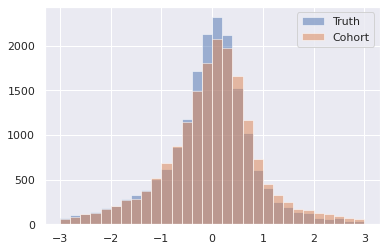

In [48]:
plt.hist(truth["logFC"],bins=30, range=(-3,3),alpha=0.5,label="Truth")
plt.hist(tab["logFC"],bins=30, range=(-3,3),alpha=0.5,label="Cohort")
plt.legend()

/storage/homefs/pd21v747/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/homefs/pd21v747/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/homefs/pd21v747/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/homefs/pd21v747/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conv

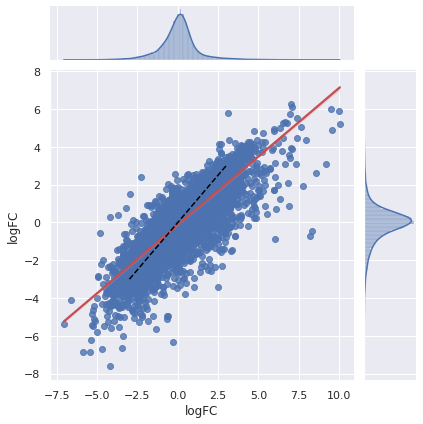

In [49]:
sns.jointplot(x=tab.loc[order,"logFC"], y=truth.loc[order,"logFC"], kind="reg", line_kws=dict(color="r"))
plt.plot((-3,3),(-3,3),ls="--",c="black")

In [28]:
if "combined_td3" not in globals():
    combined_td3 = pd.read_csv("../data/multi/combined_td.p3.csv", index_col=0) # Unpaired formal lfc 1
    #combined_td3["DEA"] = combined_td3["DEA"].str.replace("edgerqlf","edgeR QLF")

In [ ]:
combined_td3["DEA"].value_counts()

In [31]:
plot_set = tidy_df({"THCA": datasets["THCA"]} | {"BRCA": datasets["BRCA"]} | {"LIHC":datasets["LIHC"]} | {"PRAD":datasets["PRAD"]}
                                           | {"LUAD":datasets["LUAD"]} | {"COAD": datasets["COAD"]} | {"KIRC":datasets["KIRC"]}, "p1",[0,1])

plot_set.to_csv("../data/multi/combined_td_wilcox.p1.csv")

#plot_set = tidy_df(datasets, "p1", [0,1])
#plot_set = combined_td3

/storage/homefs/pd21v747/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/homefs/pd21v747/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/homefs/pd21v747/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/homefs/pd21v747/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

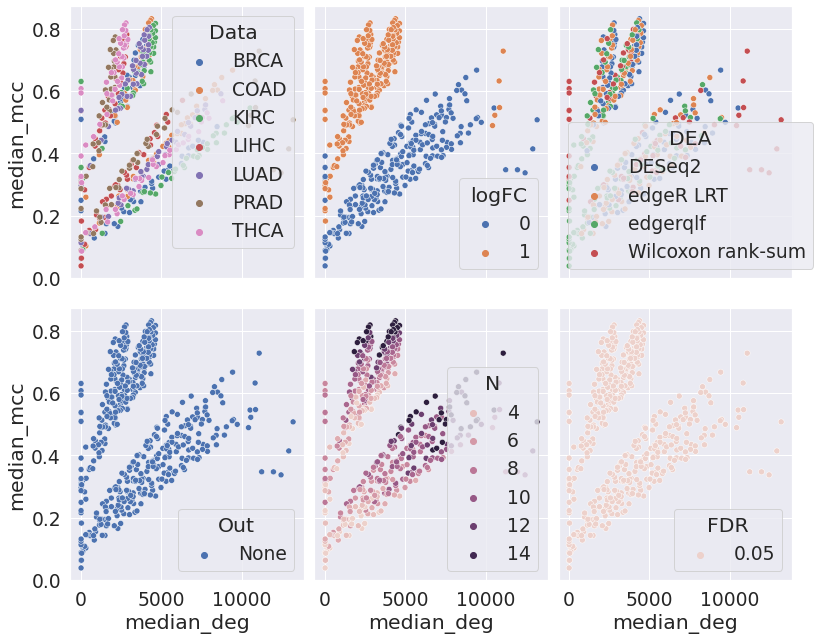

In [34]:
from misc import get_grid_size

x = "median_deg"
y = "median_mcc"

a  = plot_set#[plot_set["logFC"]==1]
#a = a[a["Data"].str.startswith("PRAD")]
a = a[a["FDR"]==0.05]
a = a[a["Out"]=="None"]

hues = ["Data","logFC","DEA","Out","N","FDR"]
grid = get_grid_size(len(hues), k=0, fill=True)
fig, ax = plt.subplots(grid[0],grid[1],figsize=(6*grid[0],3*grid[1]), sharex=True,sharey=True)
ax=ax.flatten()
cube = sns.cubehelix_palette(as_cmap=False, n_colors=5)

for i, hue in enumerate(hues):
    sns.scatterplot(data=a, x=x, y=y, hue=hue, ax=ax[i])
#for axx in ax: axx.invert_yaxis()
fig.tight_layout()

/storage/homefs/pd21v747/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/homefs/pd21v747/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/homefs/pd21v747/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/homefs/pd21v747/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

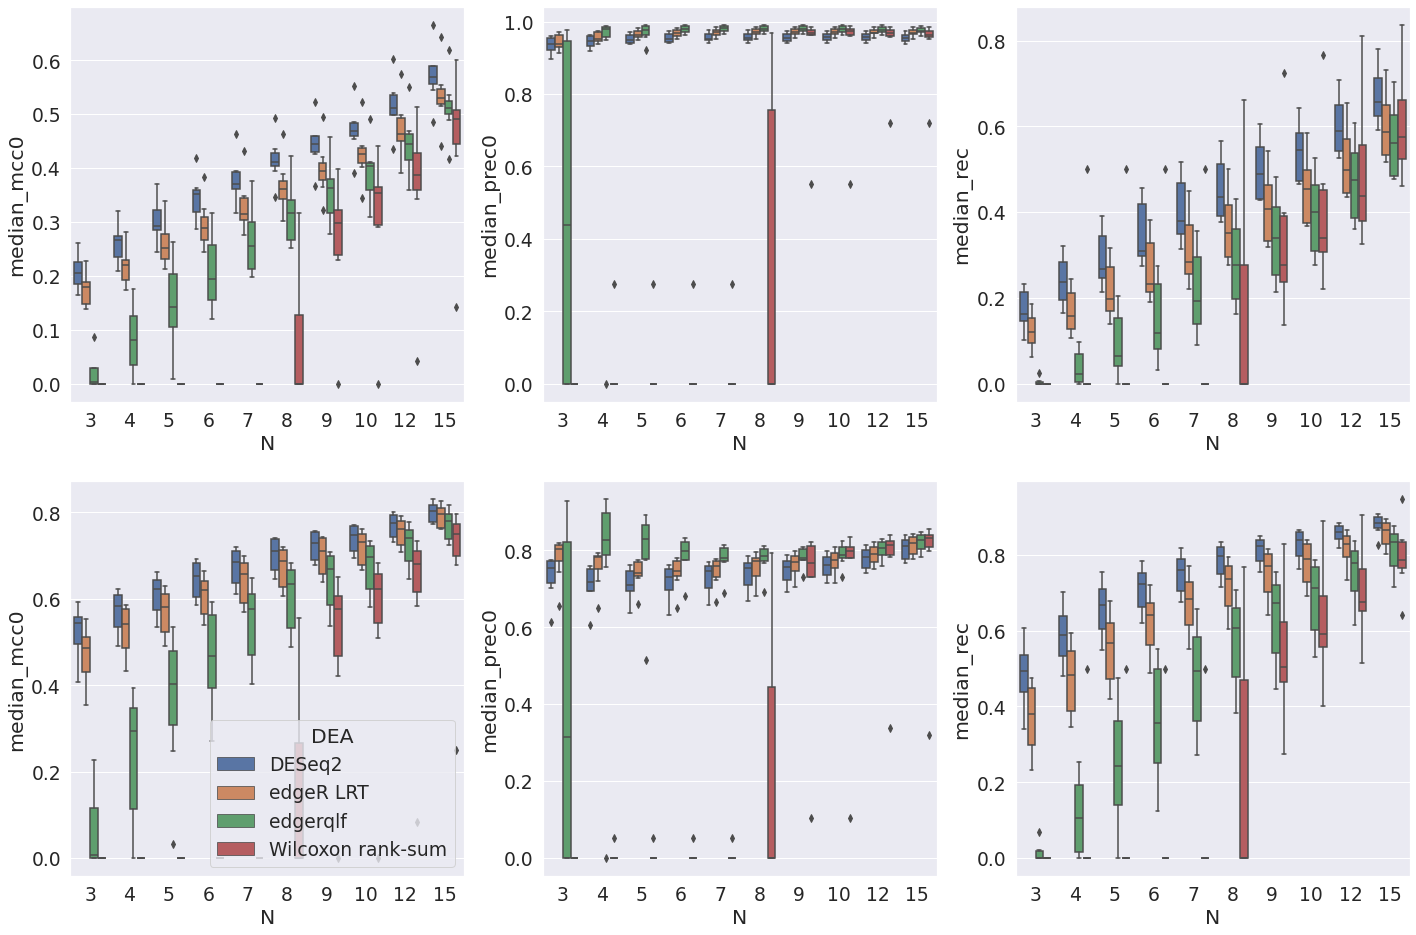

In [63]:
sns.set(font_scale=1.7)

fig, ax = plt.subplots(2,3,figsize = (24,16))
ax = ax.flatten()

a  = plot_set[plot_set["logFC"]==0]
a = a[a["FDR"]==0.05]
a = a[a["Out"]=="None"]

sns.boxplot(data=a, x="N", y="median_mcc0",hue="DEA", ax=ax[0])
sns.boxplot(data=a, x="N", y="median_prec0",hue="DEA", ax=ax[1])
sns.boxplot(data=a, x="N", y="median_rec",hue="DEA", ax=ax[2])


a  = plot_set[plot_set["logFC"]==1]
a = a[a["FDR"]==0.05]
a = a[a["Out"]=="None"]

sns.boxplot(data=a, x="N", y="median_mcc0",hue="DEA", ax=ax[3])
sns.boxplot(data=a, x="N", y="median_prec0",hue="DEA", ax=ax[4])
sns.boxplot(data=a, x="N", y="median_rec",hue="DEA", ax=ax[5])

for i in range(len(ax)):
    if i != 3:
         ax[i].legend().remove()

sns.set(font_scale=1)

In [125]:
datasets["PRAD"]["p1"][15]["none"]["wilcox"]["median_deg"][0.05][1]

11101.0

# Enrichment analysis

## Ground truth definition

Run GSEA on ground truth logFC estimates

In [3]:
from enrichment import prepare_gsea, run_gseapy_libraries, convert_ids_biomart, find_conv_table_all, clean_tab

libraries = [
  "GO_Biological_Process_2021",
  "KEGG_2021_Human"
  # "MSigDB_Oncogenic_Signatures",
  # "Cancer_Cell_Line_Encyclopedia",
  # "GO_Molecular_Function_2021",
  # "GeneSigDB",
  # "GO_Cellular_Component_2021",
  # "MSigDB_Hallmark_2020",
  # "MSigDB_Computational",
  # "WikiPathway_2021_Human"
]

cancers = ["PRAD","COAD","BRCA","KIRC","LIHC","LUAD","THCA"]

datasetsfile = Path(datapath, "multi/datasets.txt")
with open(datasetsfile, "rb") as f:
    datasets = pickle.load(f)
    
if "KIRC_syn_hom" in datasets:
    del datasets["KIRC_syn_hom"]

# Create table for converting ENSG to Gene Symbols and Entrez IDs
conv_file = Path(datapath, "multi/conv_table.csv")
find_conv_table_all(datasets, conv_file, overwrite=False)
conv_table = pd.read_csv(conv_file, index_col=0)
conv_table.head()

Existing conversion table not overwritten


,Symbol,Entrez
ENSG,,
ENSG00000143028,SYPL2,284612.0
ENSG00000188986,NELFB,25920.0
ENSG00000184786,DYNLT2,6991.0
ENSG00000166762,CATSPER2,117155.0
ENSG00000125753,VASP,7408.0


### GSEApy

In [7]:
from enrichment import prepare_gsea, run_gseapy_libraries, convert_ids_biomart, find_conv_table_all, clean_tab
from process import signal_to_noise
from DEA import normalize_counts
            
overwrite_all_gsea = False

for k, data in enumerate(datasets):
    
    outpath = datasets[data]["outpath"]
    gseapath = f"{outpath}/gsea"   
    
    if not overwrite_all_gsea: continue

    #os.system(f"mkdir {gseapath}")
    tab = pd.read_csv(f"{outpath}/truth_lfc.csv", index_col=0)

    counts = pd.read_csv(datasets[data]["datapath"], index_col=0)
    counts = normalize_counts(counts)
    tab.loc[counts.index.intersection(tab.index), "|S2N|"] = signal_to_noise(counts)

    tab_cleaned = tab.loc[tab.index.intersection(conv_table.index)]
    tab_cleaned["Symbol"] = conv_table.loc[tab_cleaned.index,"Symbol"]
    logging.info(f"{data}\nOriginal tab: {len(tab)} genes\nCleaned tab: {len(tab_cleaned)} genes\n")
    
    with Timer(name="context manager"):
        run_gseapy_libraries(tab_cleaned, gseapath, libraries, overwrite_all_gsea, permutation_num=1000, save_full_results=True,
                        ranking="logFC", min_size=15, max_size=500)
        run_gseapy_libraries(tab_cleaned, gseapath, libraries, overwrite_all_gsea, permutation_num=1000, save_full_results=True,
                            ranking="|S2N|", min_size=15, max_size=500)

In [ ]:
# Inspect results

gsea_out = f"{gseapath}/gseapy.{libraries[1]}.txt"
with open(gsea_out, "rb") as fp:
    gsea_results = pickle.load(fp)
    
print(gsea_out)

In [ ]:
import gseapy

terms = gsea_results.res2d.sort_values(by="FDR q-val")
display(gsea_results.res2d.head(10))
top_term = terms["Term"][0]
print(f"Total gene sets tested: {len(terms)}")
print(f"Significant gene sets at 5% FDR: {len(terms[terms['FDR q-val']<0.05])}\n")
gseapy.gseaplot(rank_metric=gsea_results.ranking, term=top_term, **gsea_results.results[top_term])

In [ ]:
# Make results dictionary

FDR = 0.05
rankings = ["logFC", "|S2N|"]
gsea_dict = {data: {"truth": {"gseapy": {rnk: {lib: {} for lib in libraries} for rnk in rankings}}} for data in datasets if data in cancers}

for data in datasets:
    
    outpath = datasets[data]["outpath"]
    gseapath = f"{outpath}/gsea"
    
    for rnk in rankings:
    
        for library in libraries:

            suffix = "" if rnk == "logFC" else "_s2n"
            reportfile = f"{gseapath}/gseapy{suffix}.{library}.feather"
            terms = open_table(reportfile).sort_values(by="FDR")
            gsea_dict[data]["truth"]["gseapy"][rnk][library] = terms
            print(data, library, rnk, len(terms), len(terms[terms['FDR']<FDR]))

### clusterProfiler ORA

In [ ]:
from enrichment import run_clusterORA, convert_ensg

overwrite_clusterORA = False
FDRs = [0.05]
logFCs = [0,1] # formal lfc threshold

ORA_kwargs = {"FDRs": [0.05], "logFCs": [0,1], "minGSSize": 15, "maxGSSize": 500,
               "use_internal_data": True, "internal_data_path": "../data/clusterORA/KEGG_DATA.RData"}

for k, data in enumerate(datasets):
    print(data)
    
    outpath = datasets[data]["outpath"]
    gseapath = f"{outpath}/gsea"
    #os.system(f"mkdir {gseapath}")
    universe = pd.read_csv(f"{outpath}/{data}.csv", usecols=["Unnamed: 0"], index_col=0)
    universe = list(convert_ensg(universe,conv_table,target="Entrez").index)

    for fdr in FDRs:
        for logFC in logFCs:
            degs = pd.read_csv(f"{outpath}/truth.fdr{fdr}.post_lfc{logFC}.lfc{logFC}.csv", usecols=["Unnamed: 0"], index_col=0)
            degs = list(convert_ensg(degs,conv_table,target="Entrez").index)
    
            s = "_lfc" if logFC > 0 else ""
            prefix = f"{gseapath}/clusterORA{s}.fdr{fdr}.post_lfc{logFC}.lfc{logFC}"
            run_clusterORA(degs, universe, file_id="", go_ont="BP", prefix=prefix, overwrite=overwrite_clusterORA, **ORA_kwargs)

In [ ]:
for data in datasets:
    
    outpath = datasets[data]["outpath"]
    gseapath = f"{outpath}/gsea"
        
    for fdr in FDRs:
        for logFC in logFCs:
            
            s = "_lfc" if logFC > 0 else ""
            method = f"clusterORA{s}.fdr{fdr}.post_lfc{logFC}.lfc{logFC}"
            gsea_dict[data]["truth"][method] = {lib: None for lib in libraries}
            
            for library in libraries:
                #if "KEGG" not in library: continue
                    
                reportfile = f"{gseapath}/{method}.{library}.feather"         
                terms = open_table(reportfile).sort_values(by="FDR")
                
                ## for KEGG: switch term ID and description for index
                if terms.index[0].startswith("hsa") and "Term" in terms:
                    terms["Term ID"] = terms.index
                    terms = terms.set_index("Term")
                
                gsea_dict[data]["truth"][method][library] = terms
                print(data, method, library, len(terms), len(terms[terms['FDR']<FDR]))

In [ ]:
# For KEGG ORA,set term name as index instead of term ID

for site in sites:
    for fdr in FDRs:
        for lfc in logFCs:
            s = "_lfc" if lfc > 0 else ""
            method = f"clusterORA{s}.fdr{fdr}.post_lfc{lfc}.lfc{lfc}"
            f = f"../data/{site}/{sites[site]}/gsea/{method}.KEGG_2021_Human.feather"
            t=open_table(f)
            if "Term ID" in t or t.index.name == "Term": continue
            t["Term ID"] = t.index
            t.set_index("Term",inplace=True)
            t = t.reset_index()
            t.to_feather(f)
            display(t)

### Common terms

We will define an additional, common ground truth, restricted to terms to terms that are shared between GSEApy, clusterProfiler ORA and all data sets.

In [ ]:
def get_common_terms():
    common_kegg, common_gobp = set(), set()
    for data in gsea_dict:
        for lfc in [0,1]:
            s = "_lfc" if lfc == 1 else ""
            # KEGG
            gseapy_terms = gsea_dict[data]["truth"]["gseapy"]["logFC"]["KEGG_2021_Human"].index
            clusterORA_terms = set(gsea_dict[data]["truth"][f"clusterORA{s}.fdr0.05.post_lfc{lfc}.lfc{lfc}"]["KEGG_2021_Human"].index)

            if len(common_kegg)<1: common_kegg = gseapy_terms.intersection(clusterORA_terms)
            else: common_kegg = common_kegg.intersection(gseapy_terms).intersection(clusterORA_terms)

            # GO BP
            gseapy_terms = gsea_dict[data]["truth"]["gseapy"]["logFC"]["GO_Biological_Process_2021"].index
            clusterORA_terms = gsea_dict[data]["truth"][f"clusterORA{s}.fdr0.05.post_lfc{lfc}.lfc{lfc}"]["GO_Biological_Process_2021"].index    

            if len(common_gobp)<1: common_gobp = gseapy_terms.intersection(clusterORA_terms)
            else: common_gobp = common_gobp.intersection(gseapy_terms).intersection(clusterORA_terms)

    return common_kegg, common_gobp
    
file_gobp = Path("../data/multi/common_gobp.txt")
file_kegg = Path("../data/multi/common_kegg.txt")
if (not file_gobp.is_file() or not file_kegg.is_file()):
    common_kegg, common_gobp = get_common_terms()
    pickler(common_gobp, file_gobp)
    pickler(common_kegg, file_kegg)
else:
    with open(file_gobp, "rb") as f:
        common_gobp = pickle.load(f)
    with open(file_kegg, "rb") as f:
        common_kegg = pickle.load(f)
        
print("KEGG Terms:", len(common_kegg))
print("GO BP Terms:", len(common_gobp))

As we have restricted the number of terms (hypotheses), we need to recalculate the adjusted pvalues for appropriate FDR control.

In [ ]:
from statsmodels.stats.multitest import multipletests

redo_common_fdr = True
FDRs = [0.05]
logFCs = [0,1]
rankings = ["logFC", "|S2N|"]

if redo_common_fdr:

    for data in datasets:

        outpath = datasets[data]["outpath"]
        gseapath = f"{outpath}/gsea"
        
        for library in libraries:
            
            common = common_gobp if library == "GO_Biological_Process_2021" else common_kegg
    
            ### GSEA
            for rnk in rankings:
                suffix = "" if rnk == "logFC" else "_s2n"
                reportfile = f"{gseapath}/gseapy{suffix}.{library}.feather"
                terms = open_table(reportfile).sort_values(by="FDR")
                terms["FDR.common"] = np.full(len(terms),np.nan)
                terms.loc[common, "FDR.common"] = multipletests(terms.loc[common, "NOM p-val"], method="fdr_bh")[1]
                terms.reset_index().to_feather(reportfile)


            ### ORA
            for fdr in FDRs:
                for logFC in logFCs:
                    s = "_lfc" if logFC > 0 else ""
                    method = f"clusterORA{s}.fdr{fdr}.post_lfc{logFC}.lfc{logFC}"

                    reportfile = f"{gseapath}/{method}.{library}.feather"         
                    terms = open_table(reportfile).sort_values(by="FDR")
                    #assert terms.index.duplicated().sum() == 0
                    terms["FDR.common"] = np.full(len(terms),np.nan)
                    
                    if terms.index[0].startswith("hsa"):
                        terms["hsa"] = terms.index
                        terms.set_index("Term", inplace=True)
                    
                    ix = common #if library == "GO_Biological_Process_2021" else terms[terms["Term"].isin(common)].index
                    print(data,library,fdr,logFC,method)
                    terms.loc[ix, "FDR.common"] = multipletests(terms.loc[ix, "pvalue"], method="fdr_bh")[1]
                    terms.reset_index().to_feather(reportfile)

In [ ]:
gsea_methods = ['gseapy', 'gseapy_s2n',
               'clusterORA.fdr0.05.post_lfc0.lfc0',
               'clusterORA_lfc.fdr0.05.post_lfc1.lfc1']


from process import get_n_gsea_truth
FDRs=[0.05]
gsea_param_set = "p1"
gsea_truth = {data: {out: {dea: {gsea: {lib: {"truth"+mode: {fdr: None for fdr in FDRs} for mode in ["","_common"]} for lib in libraries} for gsea in gsea_methods} for dea in DEA_methods} for out in outlier_methods} for data in datasets if "syn" not in data}

for data in datasets:
    print(data)
    outpath_d = datasets[data]["outpath"]
    outname_d = str(outpath_d).split("/")[-1]
    gsea_truth[data] = get_n_gsea_truth(gsea_truth[data], outpath_d, outname_d, all_N, DEA_methods, outlier_methods, gsea_methods, libraries, FDRs, gsea_param_set, overwrite=False)


In [ ]:
gsea_datasets = {sites[s]: {} for s in sites if sites[s] in cancers}

DEAs = DEA_methods
FDRs = [0.05]
all_N=[3]#,5,7,9,15]
    
quantity = ["truth"]
quantity += [q+"_common" for q in quantity]

iterables = [gsea_datasets,outlier_methods,DEAs,gsea_methods,libraries,FDRs,quantity]
multi_cols = pd.MultiIndex.from_product(iterables, names=["Data", "Out", "DEA", "Enrichment", "Library", "FDR", "Val"])
gsea_truth_df = pd.DataFrame(columns=multi_cols)

ids = [] # id connecting samples from same dataset and cohort size, used for paired-sample testing pre vs. post outlier removal
for d in gsea_datasets:
    for out in outlier_methods:
        for dea in DEAs:
            for gsea in gsea_methods:
                #if dea != "edger" and gsea_methods == "gsea_s2n": continue
                for fdr in FDRs:
                    for lib in libraries:
                        for quant in quantity:
                            #print(d,N,out,dea,fdr)
                            col = (d,out,dea,gsea,lib,fdr,quant)
                            if dea != "edgerqlf" and "s2n" in gsea: dea_source = "edgerqlf"
                            else: dea_source = dea
                            gsea_truth_df.loc[0,col] = gsea_truth[d][out][dea_source][gsea][lib][quant][fdr]
                            
gsea_truth_df = gsea_truth_df.unstack().unstack(level="Val").reset_index(level=["Data","Out","DEA","Enrichment","Library","FDR"], drop=False)
gsea_truth_df.reset_index(drop=True, inplace=True)

# For outlier_method == "none", no adjustment is necessary, hence copy unadjusted values
#none_ix = combined_gsea_td[combined_gsea_td["Out"] == "none"].index # avoid setting with copy warning
#combined_gsea_td.loc[none_ix,"median_terms_adj"] = combined_gsea_td.loc[none_ix,"median_terms"]
#combined_gsea_td.loc[none_ix,"median_rep_adj"] = combined_gsea_td.loc[none_ix,"median_rep"]

for clean in cleanout:
    gsea_truth_df.loc[(gsea_truth_df[gsea_truth_df["Out"] == clean]).index, "Out"] = cleanout[clean]
for clean in cleandea:
    gsea_truth_df.loc[(gsea_truth_df[gsea_truth_df["DEA"] == clean]).index, "DEA"] = cleandea[clean]
gsea_truth_df.to_csv(f"../data/multi/gsea_truth_df.csv")
gsea_truth_df.head()

## Send batch jobs

In [6]:
selected_data = "LUAD"
outpath = datasets[selected_data]["outpath"]
outname = outpath.name
outpath, outname

(PosixPath('../data/lung/LUAD'), 'LUAD')

In [7]:
from ubelix import run_gsea_batch
    
gsea_script_path = "../scripts/send_gsea_batch.sh"

n_cohorts = 2
all_N = [3]#,5,5,7,9,15]
gsea_methods = ["clusterORA_lfc","clusterORA","gseapy"] #"gseapy_s2n"
outlier_methods = ["none"]#,"jk"] #########,"pcah"]
DEA_methods = ["edgerqlf"]#["deseq2","edgerlrt"] ## reminder: do only edgerqlf for gsea S2N
libraries = ['GO_Biological_Process_2021', 'KEGG_2021_Human']

gsea_config_params = {
    
    "gsea_param_set": "p1", # id for this set of parameters
    "dea_param_set": "p1",
    "dea_param_set_lfc": "p2",
    
    "overwrite": False, # overwrite existing tabs
    "data": str(outpath) + "/" + outname + ".csv",
    "outpath": str(outpath),
    "outname": outname,
    
    "DEA_methods": DEA_methods,
    "outlier_methods": outlier_methods,
    "gsea_methods": gsea_methods,
    "libraries": libraries,
    
    "gsea_kwargs":  {
                    "gseapy_s2n": {"permutation_num": 200, "save_full_results": False, "threads": 4, "ranking":"|S2N|", "min_size": 15, "max_size": 500},
                    "gseapy": {"permutation_num": 200, "save_full_results": False, "threads": 4, "ranking":"logFC", "min_size": 15, "max_size": 500},
                    "clusterORA": {"FDRs": [0.05], "logFCs": [0], "go_ont": "BP", "ranking":"n/a", "minGSSize": 15, "maxGSSize": 500, # KIRC/COAD use minGSSize 10, no problem since we use intersection with GSEA terms afterwards
                                   "use_internal_data": True, "internal_data_path": "../data/clusterORA/KEGG_DATA.RData"},
                    "clusterORA_lfc": {"FDRs": [0.05], "logFCs": [1], "go_ont": "BP", "ranking":"n/a", "minGSSize": 15, "maxGSSize": 500,
                                   "use_internal_data": True, "internal_data_path": "../data/clusterORA/KEGG_DATA.RData"}
                    } 
}


mode = "send jobs"
#mode = "test main"
mode = "just testing"
sleep_seconds = 0

run_gsea_batch(gsea_config_params, all_N, n_cohorts, libraries, gsea_script_path=gsea_script_path, mode=mode, sleep_seconds=sleep_seconds)


Testing 0 jobs for N=3, DEA=edgerqlf, out=none, GSEA=clusterORA_lfc, max time: 4 min

Testing 0 jobs for N=3, DEA=edgerqlf, out=none, GSEA=clusterORA, max time: 4 min

Testing 0 jobs for N=3, DEA=edgerqlf, out=none, GSEA=gseapy, max time: 6 min
Total jobs: 0


In [8]:
!squeue -u pd21v747

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          10914291     epyc2 jupyter_ pd21v747  R      15:03      1 bnode041


In [20]:
# data = "THCA"
# N = 3
# library = libraries[0]
# cohort = 1
# dea = "edgerqlf"
# out = "none"
# gsea_method = "clusterORA_lfc.fdr0.05.post_lfc1.lfc1"
# param_set = "p1"
# site = datasets[data]["site"]
# p=f"../data/{site}/{data}/{data}_N{N}/{data}_N{N}_{cohort:04}/gsea/{gsea_method}.{library}.{dea}.{out}.{param_set}.feather"
# t=open_table(p)
# print(len(t[t["FDR"]<0.05]))
# t.sort_values(by="FDR")

## Process jobs

In [ ]:
import sys, importlib
importlib.reload(sys.modules["process"])

from process import gsea_process_pipeline
gFDRs = [0.05]
gsea_methods = ["clusterORA_lfc.fdr0.05.post_lfc1.lfc1", "gseapy","clusterORA.fdr0.05.post_lfc0.lfc0", "gseapy_s2n", "clusterORA.fdr0.05.post_lfc1.lfc0"]
DEA_methods = ["edgerqlf", "deseq2", "edgerlrt"]
all_N = [3,5,7,9,15] 

import subprocess as sp
output = sp.getoutput('squeue -u pd21v747')
jobs_running = output.find("send_gse") > 0

if not jobs_running:
    gsea_process_pipeline(outpath, outname, all_N, DEA_methods, outlier_methods, gsea_methods, libraries, 
                          gFDRs, "p1", overwrite=1, overwrite_merged=0, n_cohorts=50, calculate_common=1)
    # when adding new method: overwrite merged and calculcate common only with new method, then only overwrite with all emthods

In [34]:
# f="/storage/homefs/pd21v747/RNASeqReplicability/data/liver/LIHC/gsea_results.txt"
# with open(f, "rb") as ff:
#     gs = pickle.load(ff)
    
# gs

## Merge processed data sets

In [12]:
gsea_datasets = {sites[s]: {} for s in sites if sites[s] in cancers}

def load_gsea_results(path, site, name):
    resultsfile = f"{path}/{site}/{name}/gsea_results.txt"
    with open(resultsfile, "rb") as f:
        return pickle.load(f)
    
for s in sites:
    if s not in ["breast","colorectal","kidney","lung","liver","prostate","thyroid"]: continue
    gsea_datasets[sites[s]]["site"] = s
    res = load_gsea_results(datapath, s, sites[s])
    for key in res.keys():
        gsea_datasets[sites[s]][key] = res[key]

gsea_datasetsfile = "../data/multi/gsea_datasets.txt"
pickler(gsea_datasets, gsea_datasetsfile)

In [13]:
# Create tidy dataframe

DEAs = DEA_methods
FDRs = [0.05]
all_N=[3,5,7,9,15]

    
quantity = ["median_rep", "median_terms","median_mcc0", "median_prec0",
            "median_mcc", "median_prec", "median_rec"]
quantity += [q+"_common" for q in quantity]

iterables = [gsea_datasets,all_N,outlier_methods,DEAs,gsea_methods,libraries,FDRs,quantity]
multi_cols = pd.MultiIndex.from_product(iterables, names=["Data", "N", "Out", "DEA", "Enrichment", "Library", "FDR", "Val"])
combined = pd.DataFrame(columns=multi_cols)

ids = [] # id connecting samples from same dataset and cohort size, used for paired-sample testing pre vs. post outlier removal
for i, d in enumerate(gsea_datasets):
    for j, N in enumerate(all_N):
        k = i*len(all_N)+j 
        for out in outlier_methods:
            for dea in DEAs:
                for gsea in gsea_methods:
                    #if dea != "edger" and gsea_methods == "gsea_s2n": continue
                    for fdr in FDRs:
                        for lib in libraries:
                            for quant in quantity:
                                try:
                                    col = (d,N,out,dea,gsea,lib,fdr,quant)
                                    combined.loc[0,col] = gsea_datasets[d][N][out][dea][gsea][lib][quant][fdr]
                                    if quant == "median_rep": ids.append(k)
                                except KeyError:
                                    print(d,N,out,dea,fdr)
                                    assert 0
                            
combined_gsea_td = combined.unstack().unstack(level="Val").reset_index(level=["Data","N","Out","DEA","Enrichment","Library","FDR"], drop=False)
combined_gsea_td["id"] = ids
combined_gsea_td.reset_index(drop=True, inplace=True)

# For outlier_method == "none", no adjustment is necessary, hence copy unadjusted values
#none_ix = combined_gsea_td[combined_gsea_td["Out"] == "none"].index # avoid setting with copy warning
#combined_gsea_td.loc[none_ix,"median_terms_adj"] = combined_gsea_td.loc[none_ix,"median_terms"]
#combined_gsea_td.loc[none_ix,"median_rep_adj"] = combined_gsea_td.loc[none_ix,"median_rep"]

for clean in cleanout:
    combined_gsea_td.loc[(combined_gsea_td[combined_gsea_td["Out"] == clean]).index, "Out"] = cleanout[clean]
for clean in cleandea:
    combined_gsea_td.loc[(combined_gsea_td[combined_gsea_td["DEA"] == clean]).index, "DEA"] = cleandea[clean]
combined_gsea_td.to_csv(f"../data/multi/combined_gsea_td.csv")
combined_gsea_td.head()

Val,Data,N,Out,DEA,Enrichment,Library,FDR,median_mcc,median_mcc0,median_mcc0_common,...,median_prec0,median_prec0_common,median_prec_common,median_rec,median_rec_common,median_rep,median_rep_common,median_terms,median_terms_common,id
0,BRCA,3,None,DESeq2,clusterORA.fdr0.05.post_lfc0.lfc0,GO_Biological_Process_2021,0.05,0.200693,0.200693,0.157256,...,0.480867,0.67898,0.67898,0.281293,0.351077,0.378828,0.448421,853.0,422.0,0
1,BRCA,3,None,DESeq2,clusterORA.fdr0.05.post_lfc0.lfc0,KEGG_2021_Human,0.05,0.011757,0.011757,0.007589,...,0.227778,0.236111,0.236111,0.057971,0.093023,0.214286,0.237288,17.5,18.0,0
2,BRCA,3,None,DESeq2,clusterORA.fdr0.05.post_lfc1.lfc0,GO_Biological_Process_2021,0.05,0.575493,0.575493,0.579915,...,0.781781,0.827571,0.827571,0.56824,0.605166,0.380916,0.449664,851.5,422.0,0
3,BRCA,3,None,DESeq2,clusterORA.fdr0.05.post_lfc1.lfc0,KEGG_2021_Human,0.05,0.442178,0.442178,0.430878,...,0.682105,0.761663,0.761663,0.363636,0.361111,0.21875,0.243902,18.5,18.5,0
4,BRCA,3,None,DESeq2,clusterORA_lfc.fdr0.05.post_lfc1.lfc1,GO_Biological_Process_2021,0.05,0.379003,0.372622,0.380077,...,0.838146,0.890171,0.890171,0.254113,0.282609,0.156448,0.183168,335.0,167.5,0


## Inspect results

In [ ]:
from misc import get_grid_size

x = "median_mcc0_common"
y = "median_rep_common"

a  = combined_gsea_td
#a = a[a["Library"]=="KEGG_2021_Human"]
hues = ["Data","Library","DEA","Out","N", "Enrichment"]
grid = get_grid_size(len(hues), k=0, fill=True)
fig, ax = plt.subplots(grid[0],grid[1],figsize=(6*grid[0],3*grid[1]), sharex=True,sharey=True)
ax=ax.flatten()

for i, hue in enumerate(hues):
    sns.scatterplot(data=a, x=x, y=y, hue=hue, ax=ax[i])    
    ax[i].invert_yaxis()
fig.tight_layout()

# Misc.

## Filter low-expressed genes

In [19]:
from R_wrappers import filterByExpr_wrapper

f = "/storage/homefs/pd21v747/RNASeqReplicability/data/GSEBP/BPLT/BPLT.csv"

outfile_filtered = f.replace(".csv","_filtered.csv")
filterByExpr_wrapper(inpath=f, outpath=outfile_filtered, design="unpaired")

## Test DEA

In [3]:
from misc import paired_replicate_sampler

N = 15
f = "/storage/homefs/pd21v747/RNASeqReplicability/data/GSEBP/BPLT/BPLT.csv"
f = "/storage/homefs/pd21v747/RNASeqReplicability/data/kidney/KIRC/KIRC.csv"
f = "/storage/homefs/pd21v747/RNASeqReplicability/data/prostate/PRAD/PRAD.csv"
f = "/storage/homefs/pd21v747/RNASeqReplicability/data/thyroid/THCA/THCA.csv"
#f = "../data/GSEPN/GIPF/GIPF.csv"

tab = pd.read_csv(f, index_col=0)

try:
    df = paired_replicate_sampler(tab, N)[0]
except:
    c = tab.columns.str.startswith("control").sum()
    m = min(c, tab.columns.str.startswith("ipf").sum())
    tab = tab.iloc[:,list(range(m))+list(range(c,c+m))]
    df = paired_replicate_sampler(tab, N)[0]
    
from DEA import normalize_counts
df_norm = normalize_counts(df)

R[write to console]: Loading required package: limma

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [ ]:
from DEA import run_dea

design_file = "../data/GSEPN/GIPF/GIPF.meta.csv"
design = pd.read_csv(design_file, index_col=0)
design_file_N = "../data/test/test.design.csv"
design = design.loc[df.columns]
design.to_csv(design_file_N)

outfile = f"/storage/homefs/pd21v747/RNASeqReplicability/data/test/test.controlled.N{N}.csv"
edgerqlf_kwargs = {"filter_expr": False, "cols_to_keep": ["logFC","logCPM","FDR"], "lfc": 0, "design": design_file_N, "check_gof": False,
                  "verbose":True}
run_dea(df, outfile, "edgerqlf", True, **edgerqlf_kwargs)

In [182]:
outfile_uncontrolled = f"/storage/homefs/pd21v747/RNASeqReplicability/data/test/test.uncontrolled.N{N}.csv"
edgerqlf_kwargs = {"filter_expr": False, "cols_to_keep": ["logFC","logCPM","FDR"], "lfc": 0, "design": "unpaired", "check_gof": False,
                  "N_control": N, "N_treat": N}
run_dea(df, outfile_uncontrolled, "edgerqlf", True, **edgerqlf_kwargs)


Calling edgeR in R with kwargs:
{'filter_expr': False, 'cols_to_keep': ['logFC', 'logCPM', 'FDR'], 'check_gof': False, 'N_control': 4, 'N_treat': 4}

[1] 8
[1] 8


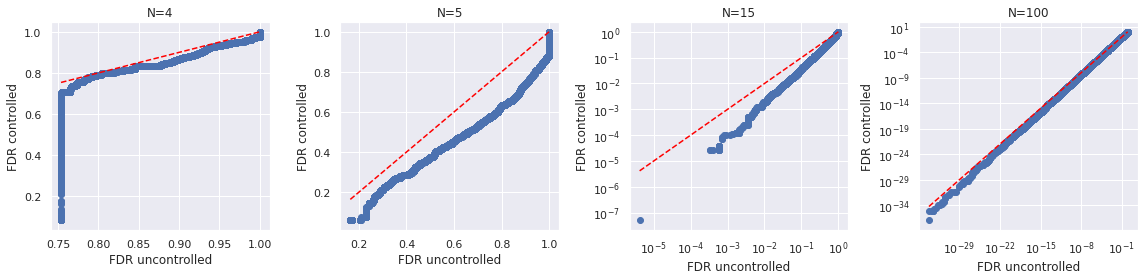

In [184]:
all_N = [4,5,15,100]

fig, ax = plt.subplots(1,len(all_N),figsize=(4*len(all_N),4))
ax = ax.flatten()

for i, n in enumerate(all_N):

    outfile = f"/storage/homefs/pd21v747/RNASeqReplicability/data/test/test.controlled.N{n}.csv"
    outfile_uncontrolled = f"/storage/homefs/pd21v747/RNASeqReplicability/data/test/test.uncontrolled.N{n}.csv"

    res = pd.read_csv(outfile, index_col=0)
    res2 = pd.read_csv(outfile_uncontrolled, index_col=0)

    ax[i].scatter(res["FDR"],res2["FDR"])
    ax[i].plot( (min(res["FDR"]),1), (min(res["FDR"]),1), ls="--",c="red")
    if n > 5:
        ax[i].set_xscale("log")
        ax[i].set_yscale("log")
    ax[i].set_xlabel("FDR uncontrolled")
    ax[i].set_ylabel("FDR controlled")
    ax[i].set_title(f"N={n}")
    
    #ax[i].set_xlim(min(min(res["FDR"]),min(res2["FDR"])), 1)
    #ax[i].set_ylim(min(min(res["FDR"]),min(res2["FDR"])), 1)
    
fig.tight_layout()

In [19]:
from DEA import run_dea

outfile = "/storage/homefs/pd21v747/RNASeqReplicability/data/test/goftest.csv"

edgerqlf_kwargs = {"filter_expr": False, "cols_to_keep": ["logFC","logCPM","FDR"], "lfc": 0, "design": "paired", "check_gof": True}
        
run_dea(df, outfile, "edgerqlf", True, **edgerqlf_kwargs)


Calling edgeR in R with kwargs:
{'filter_expr': False, 'cols_to_keep': ['logFC', 'logCPM', 'FDR'], 'check_gof': True}

[1] 16
[1] 16
[1] "Saved gof in /storage/homefs/pd21v747/RNASeqReplicability/data/test/gof.goftest.csv"


In [20]:
res = pd.read_csv(outfile, index_col=0)
sig = res[res["FDR"]<0.05]
print(len(sig))
res

6521


,logFC,logCPM,FDR
ENSG00000177191,2.778000,2.236187,0.000266
ENSG00000231768,-3.351945,0.250914,0.000266
ENSG00000115380,-2.494010,7.063168,0.000352
ENSG00000132535,1.707723,4.632506,0.000352
ENSG00000153823,-3.496012,2.293208,0.000352
...,...,...,...
ENSG00000270761,0.000395,-0.297885,0.999492
ENSG00000142583,0.000132,0.837702,0.999492
ENSG00000089723,0.000070,-0.196010,0.999838
ENSG00000278993,-0.000249,-0.280506,1.000000


In [ ]:
sortedfit = gof.sort_values(by="x").index

logFC     0.582072
logCPM   -1.298709
FDR       0.021888
Name: ENSG00000281741, dtype: float64


(array([18.,  6.,  0.,  2.,  1.,  1.,  0.,  0.,  1.,  1.]),
 array([  0. ,  14.3,  28.6,  42.9,  57.2,  71.5,  85.8, 100.1, 114.4,
        128.7, 143. ]),
 <BarContainer object of 10 artists>)

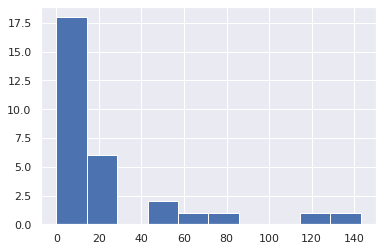

In [24]:
g = sortedfit[1]
print(res.loc[g])

plt.hist(df.loc[g])

In [ ]:
g = outfile.split("/")
g[-1] = "gof." + g[-1]
gof_file = "/".join(g)
gof = pd.read_csv(gof_file, index_col=0)

assert len(res) == len(gof)
gof.index = res.index

#gof.loc[sig.index].hist()
gof.hist()
plt.xlabel("pvalue goodness-of-fit")

Text(0, 0.5, 'pval goodness-of-fit')

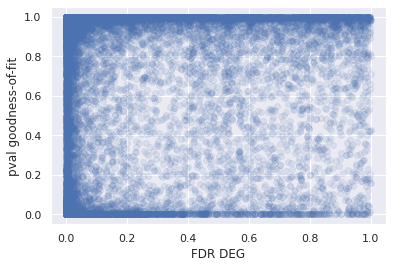

In [29]:
plt.scatter(res["FDR"], gof["x"], alpha=0.1)
plt.xlabel("FDR DEG")
plt.ylabel("pval goodness-of-fit")

## Wilcoxon

In [3]:
from misc import paired_replicate_sampler

N = 3
f = "/storage/homefs/pd21v747/RNASeqReplicability/data/GSEBP/BPLT/BPLT.csv"
f = "/storage/homefs/pd21v747/RNASeqReplicability/data/kidney/KIRC/KIRC.csv"
f = "/storage/homefs/pd21v747/RNASeqReplicability/data/prostate/PRAD/PRAD.csv"
f = "/storage/homefs/pd21v747/RNASeqReplicability/data/thyroid/THCA/THCA.csv"
#f = "../data/GSEPN/GIPF/GIPF.csv"

tab = pd.read_csv(f, index_col=0)

try:
    df = paired_replicate_sampler(tab, N)[0]
except:
    c = tab.columns.str.startswith("control").sum()
    m = min(c, tab.columns.str.startswith("ipf").sum())
    tab = tab.iloc[:,list(range(m))+list(range(c,c+m))]
    df = paired_replicate_sampler(tab, N)[0]

In [7]:
from scipy.stats import ranksums, wilcoxon
from statsmodels.stats.multitest import multipletests
from DEA import normalize_counts

def wilcox_test(df_unnormalized, design, outfile="", overwrite=False):
    """Perform Wilcoxon rank sum test for each gene"""
    
    if design == "paired":
        if len(df_unnormalized.columns) % 2 != 0:
            raise Exception("df must have even number of columns for paired design")
        test_func = wilcoxon

    elif design == "unpaired":
        test_func = ranksums
    else:
        raise Exception("General design matrix not supported, must be paired or unpaired")
        
    if os.path.isfile(outfile) and not overwrite:
        logging.info("Existing file not overwritten")
        return
    
    df = normalize_counts(df_unnormalized)
    wilcoxon_results = {}
    for i, gene in enumerate(df.index):
        control_values = df.iloc[i, :len(df.columns)//2]
        treatment_values = df.iloc[i, len(df.columns)//2:]

        try:
            statistic, p_value = test_func(control_values, treatment_values)
        except ValueError:
            statistic, p_value = np.nan, np.nan
        
        wilcoxon_results[gene] = {'statistic': statistic, 'p_value': p_value}

    wilcoxon_results_df = pd.DataFrame.from_dict(wilcoxon_results, orient='index')
    p_values = wilcoxon_results_df['p_value']
    
    _, corrected_p_values, _, _ = multipletests(p_values.dropna(), method='fdr_bh')
    wilcoxon_results_df.loc[~wilcoxon_results_df['p_value'].isna(), 'FDR'] = corrected_p_values    

    if outfile != "":
        save_df(wilcoxon_results_df, outfile)
    return wilcoxon_results_df


def save_df(df, path):
    file_extension = path.split('.')[-1].lower()
    if file_extension == 'csv':
        df.to_csv(path)
    elif file_extension == 'feather':
        df.to_feather(path)
    else:
        raise ValueError("Unsupported file extension. Supported extensions are: .csv and .feather")

In [8]:
from DEA import run_dea

outfile = "/storage/homefs/pd21v747/RNASeqReplicability/data/test/test.csv"
edgerqlf_kwargs = {"filter_expr": False, "cols_to_keep": ["logFC","logCPM","FDR"], "lfc": 0, "design": "paired"}
run_dea(df, outfile, "edgerqlf", True, **edgerqlf_kwargs)
res = pd.read_csv(outfile, index_col=0)
sig = res[res["FDR"]<0.05]
print(len(sig))


Calling edgeR in R with kwargs:
{'filter_expr': False, 'cols_to_keep': ['logFC', 'logCPM', 'FDR']}

[1] 6
[1] 6
90


In [9]:
outfile="/storage/homefs/pd21v747/RNASeqReplicability/data/test/wilcox_test_unpaired.csv"
wilcoxon_results_df_unpaired = wilcox_test(df, outfile=outfile, design="unpaired", overwrite=True)

outfile="/storage/homefs/pd21v747/RNASeqReplicability/data/test/wilcox_test.csv"
wilcoxon_results_df_pair = wilcox_test(df, outfile=outfile, design="paired", overwrite=True)

/storage/homefs/pd21v747/.local/lib/python3.9/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/storage/homefs/pd21v747/.local/lib/python3.9/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


/storage/homefs/pd21v747/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/homefs/pd21v747/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/homefs/pd21v747/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/homefs/pd21v747/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conv

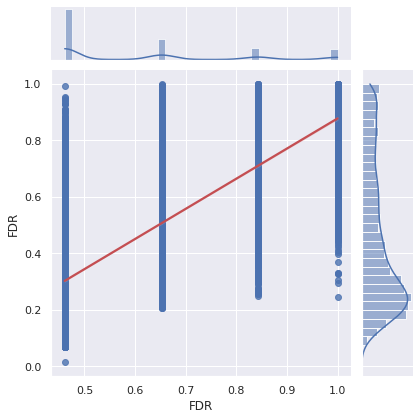

In [110]:
sns.jointplot(x=wilcoxon_results_df_pair["FDR"], y=res["FDR"], kind="reg", line_kws=dict(color="r"))

/storage/homefs/pd21v747/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/homefs/pd21v747/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/homefs/pd21v747/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/homefs/pd21v747/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conv

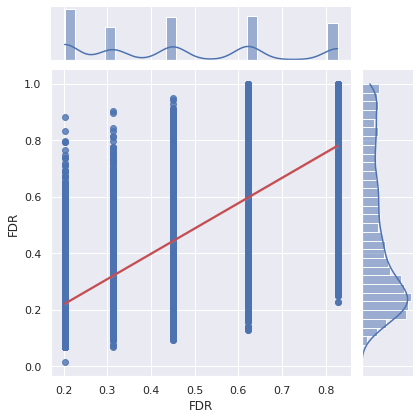

In [111]:
sns.jointplot(x=wilcoxon_results_df_unpaired["FDR"], y=res["FDR"], kind="reg", line_kws=dict(color="r"))

/storage/homefs/pd21v747/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/homefs/pd21v747/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/homefs/pd21v747/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/homefs/pd21v747/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conv

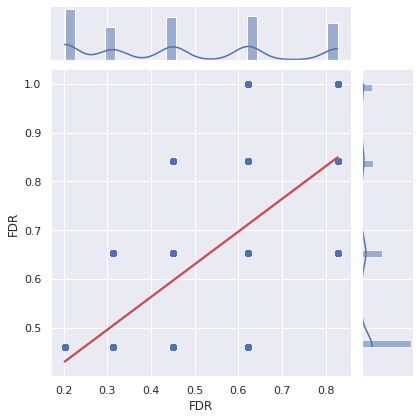

In [112]:
sns.jointplot(x=wilcoxon_results_df_unpaired["FDR"], y=wilcoxon_results_df_pair["FDR"], kind="reg", line_kws=dict(color="r"))

In [38]:
sig_wrs = wilcoxon_results_df[wilcoxon_results_df["FDR"]<0.05]
print(len(sig.index), len(sig_wrs), len(sig.index.intersection(sig_wrs.index)))

sig_wrs_norm = wilcoxon_results_df_norm[wilcoxon_results_df_norm["FDR"]<0.05]
print(len(sig.index), len(sig_wrs_norm), len(sig.index.intersection(sig_wrs_norm.index)))

len(sig_wrs.index.intersection(sig_wrs_norm.index))

6521 0 0
6521 0 0


0

### Formal

In [74]:
df_norm = normalize_counts(df)

In [106]:
control_values = df_norm.iloc[:, :len(df_norm.columns)//2] + 1
treatment_values = df_norm.iloc[:, len(df_norm.columns)//2:] + 1
control_values.columns = [c[1:] for c in control_values.columns]
treatment_values.columns = [c[1:] for c in treatment_values.columns]

control_values = np.log2(control_values)
treatment_values = np.log2(treatment_values)

lfc_thresh = 0
#treatment_values -= 2**lfc_thresh

_, p_values = wilcoxon(control_values, treatment_values, axis=1, alternative="greater")

_, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh')

/storage/homefs/pd21v747/.local/lib/python3.9/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [108]:
(control_values-treatment_values).mean()

1     0.124101
2     0.075217
4     0.064173
5    -0.068916
6     0.098260
10   -0.044619
12   -0.119854
22   -0.088009
24    0.023652
26   -0.020576
32    0.162197
34    0.053852
37   -0.014681
40   -0.049247
47   -0.099696
dtype: float64

15780

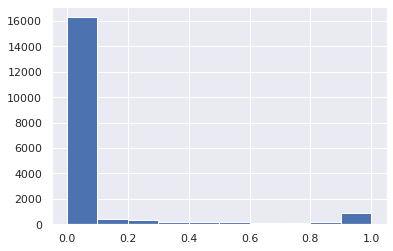

In [92]:
plt.hist(corrected_p_values)
(corrected_p_values < 0.05).sum()

In [15]:
wilcoxon_results = {}
for i, gene in enumerate(df_norm.index):
    if i > 100: break
    control_values = df_norm.iloc[i, :len(df_norm.columns)//2]
    treatment_values = df_norm.iloc[i, len(df_norm.columns)//2:]

    try:
        statistic, p_value = wilcoxon(control_values, treatment_values)
    except ValueError:
        statistic, p_value = np.nan, np.nan

    wilcoxon_results[gene] = {'statistic': statistic, 'p_value': p_value}

wilcoxon_results_df = pd.DataFrame.from_dict(wilcoxon_results, orient='index')
p_values = wilcoxon_results_df['p_value']

_, corrected_p_values, _, _ = multipletests(p_values.dropna(), method='fdr_bh')
wilcoxon_results_df.loc[~wilcoxon_results_df['p_value'].isna(), 'FDR'] = corrected_p_values  

## Misc.

In [25]:
from process import delete_redundant_slurmfiles

delete_redundant_slurmfiles(outpath, outname, all_N)            

N3: Removed 0 slurm files
N7: Removed 0 slurm files
N15: Removed 0 slurm files


In [40]:
import sys, importlib
importlib.reload(sys.modules["misc"])
importlib.reload(sys.modules["DEA"])
importlib.reload(sys.modules["process"])
importlib.reload(sys.modules["ubelix"])

<module 'ubelix' from '/storage/homefs/pd21v747/RNASeqReplicability/notebooks/../scripts/ubelix.py'>

In [ ]:
for file in BRCA.*; do
    new_name="BRCA_unpaired.${file#*.}"
    mv "$file" "$new_name"
done